# Summary

This notebook explores the distribution of bounding box ROIs post-alignment. This range of values is used to inform the hyperparameter testing range (the optimal amount to pad the bounding box for cascaded alignment).

# Imports

In [1]:
# imports

import os, sys, time
from joblib import Parallel, delayed

import numpy as np
import pandas as pd

from pandas import DataFrame as DF

import SimpleITK as sitk

from helpers_general import sitk2np, mask2sitk, print_sitk_info, round_tuple, lrange, lmap, get_roi_range, numbers2groups
from helpers_preprocess import mask2bbox, print_bbox, get_bbox_size, print_bbox_size, get_data_dict, folder2objs, \
                                threshold_based_crop, get_reference_frame, resample2reference

from helpers_metrics import compute_dice_coefficient, compute_coverage_coefficient
from helpers_viz import viz_axis

In [2]:
# auto-reload when local helper fns change
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Data

- Load data from folder (train_path)
- Crop to foreground
- Get standard reference domain
- Resample to sample reference domain

Load data from folder (train_path)

In [3]:
# Data path

PROJ_PATH = "."

# Folders containing MR train data
train_path = f"{PROJ_PATH}/train_data/train_data"
train_data_dict = get_data_dict(train_path)

# print train data dict
print(f"Train data folders: {numbers2groups(sorted([int(x) for x in os.listdir(train_path)]))}")
print(f"Training data (size {len(train_data_dict)}): key = train folder, value = full path to (segm obj, nii file)\n")

# Get folders

folders     = sorted([int(x) for x in os.listdir(train_path)])
nii_paths   = [train_data_dict[str(folder)][1] for folder in folders]

Train data folders: [range(50002, 50017), range(50019, 50020), 50049, range(50455, 50464)]
Training data (size 29): key = train folder, value = full path to (segm obj, nii file)



Read metadata in training data to determine standard reference frame (px dimensions and physical extent)

In [4]:
def get_img_data(path):
    reader = sitk.ImageFileReader()
    reader.SetFileName(path)
    reader.ReadImageInformation()
    return  reader.GetSize(), reader.GetSpacing() #reader.GetDirection()

def get_reference_frame(all_img_data):
    img_data = all_img_data
    
    dimension = 3 # 3D MRs
    pixel_id = 2 # 16-bit signed integer

    # Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
    reference_physical_size = np.zeros(dimension)

    for img_sz, img_spc in img_data:
        reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx else mx \
                                      for sz, spc, mx in zip(img_sz, img_spc, reference_physical_size)]

    #print(reference_physical_size)
    # Create the reference image with a zero origin, identity direction cosine matrix and dimension     
    reference_origin = np.zeros(dimension)
    reference_direction = np.identity(dimension).flatten()


    # Isotropic (1,1,1) pixels
    reference_spacing = np.ones(dimension)
    reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]

    # Set reference image attributes
    reference_image = sitk.Image(reference_size, pixel_id)
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))
    return reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center

def get_reference_image(reference_frame):
    reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center = reference_frame
    reference_image = sitk.Image(reference_size, pixel_id)
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)
    return reference_image, reference_center

In [5]:
all_img_data = [get_img_data(path) for path in nii_paths]

reference_frame = get_reference_frame(all_img_data)
reference_image, reference_center = get_reference_image(reference_frame)

# print 
print("Reference Frame")
print_sitk_info(reference_image)

Reference Frame
Size:  (191, 268, 268)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer


In [6]:
# Define which folders to load
obj_range = lrange(50002, 50017+1)

In [7]:
def idx2obj(idx):
    # load obj => crop obj => resample2reference
    # 10 MRs labelled by Dr. Hollon, need nii LPS=>RAS adjustment for the mask
    ras_range = range(50455, 50464+1)
    return resample2reference(*threshold_based_crop(*folder2objs(str(idx), train_data_dict, idx in ras_range)),
                             reference_image, reference_center)

# No need for threshold based crop if resampled
def idx2arr(idx):
    # load obj => crop obj => resample2reference => arr
    # 10 MRs labelled by Dr. Hollon, need nii LPS=>RAS adjustment for the mask
    ras_range = range(50455, 50464+1)
    return (sitk2np(o) for o in resample2reference(*folder2objs(str(idx), train_data_dict, idx in ras_range),
                             reference_image, reference_center))

In [8]:
start = time.time()
img_arr, mask_arr = idx2arr(obj_range[0])
elapsed = time.time() - start
print(f"Elapsed {elapsed:.2f} s")

Elapsed 3.43 s


In [9]:
start = time.time()
img_obj, mask_obj = idx2obj(obj_range[0])
elapsed = time.time() - start
print(f"Elapsed {elapsed:.2f} s")

Elapsed 3.98 s


In [10]:
print("Resampled (RS) Img Obj"); print_sitk_info(img_obj); print()
print("Resampled (RS) Mask Obj"); print_sitk_info(mask_obj); print()
print("Mask bbox"); print_bbox(*mask2bbox(sitk2np(mask_obj)))

Resampled (RS) Img Obj
Size:  (191, 268, 268)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 8 = 32-bit float

Resampled (RS) Mask Obj
Size:  (191, 268, 268)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 1 = 8-bit unsigned integer

Mask bbox
Bbox coords: (82, 148, 122) to (121, 177, 144). Size: 39, 29, 22.
Bounding box coord: from location (148, 122) of slice 82 to location (177, 144) of slice 121.


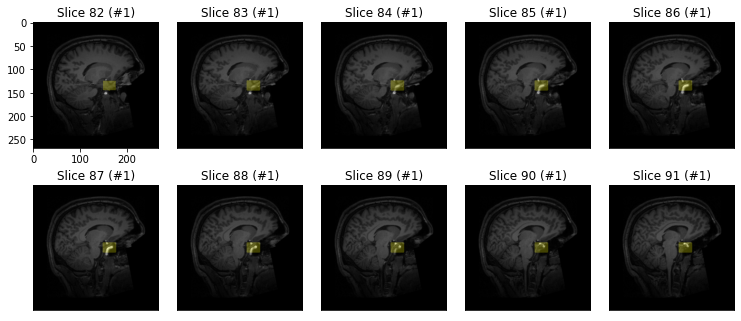

In [11]:
# viz
# Row 1 = resampled img obj, resampled mask obj
viz_axis(np_arr = sitk2np(img_obj), \
        bin_mask_arr   = sitk2np(mask_obj), color1 = "yellow", alpha1=0.3, \
        slices=lrange(82,92), fixed_axis=0, \
        axis_fn = np.rot90, \
         
#         np_arr_b = sitk2np(cropped_input_obj), \
#         bin_mask_arr_b   = sitk2np(cropped_input_mask_obj), color1_b = "yellow", alpha1_b=0.3, \
#         bin_mask_arr2_b  = sitk2np(pred_mask_obj2), color2_b = "red", alpha2_b=0.3, \
#         slices_b = lrange(35,41), fixed_axis_b=0, \
#         axis_fn_b = np.rot90, \
         
        grid = [2, 5], hspace=0.3, fig_mult=2)

Test conversion between np arr/sitk obj.

Since sitk obj has standardized origin, spacing, and direction, np arr contains all the info.

In [12]:
from helpers_general import np2sitk

 Obj Size: (191, 268, 268), Arr Shape: (191, 268, 268)
Original
Size:  (191, 268, 268)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 8 = 32-bit float

Reconvterted
Size:  (191, 268, 268)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 8 = 32-bit float



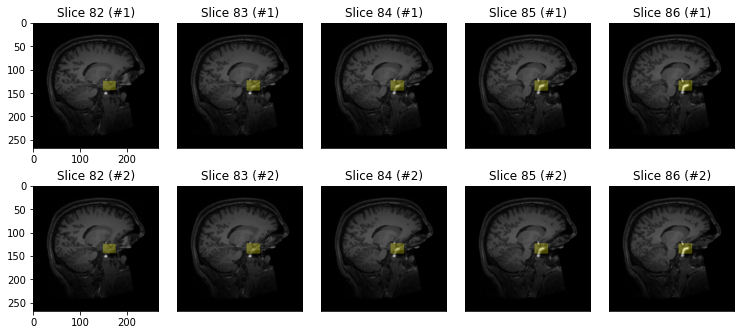

In [15]:
img_arr  = sitk2np(img_obj)
mask_arr = sitk2np(mask_obj)

print(f" Obj Size: {img_obj.GetSize()}, Arr Shape: {img_arr.shape}")

reconverted_obj  = np2sitk(img_arr)
reconverted_mask = np2sitk(mask_arr)

print("Original"); print_sitk_info(img_obj); print();
print("Reconvterted"); print_sitk_info(reconverted_obj); print();

# _, _, reference_origin, reference_spacing, reference_direction, _ = reference_frame
# test_bk.SetOrigin(reference_origin)
# test_bk.SetSpacing(reference_spacing)
# test_bk.SetDirection(reference_direction)

# viz
# Row 1 = resampled img obj, resampled mask obj
# Row 2 = reconverted img obj, reconverted mask bj

viz_axis(np_arr = sitk2np(img_obj), \
        bin_mask_arr   = sitk2np(mask_obj), color1 = "yellow", alpha1=0.3, \
        slices=lrange(82,87), fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = sitk2np(reconverted_obj), \
        bin_mask_arr_b   = sitk2np(reconverted_mask), color1_b = "yellow", alpha1_b=0.3, \
        slices_b = lrange(82,87), fixed_axis_b=0, \
        axis_fn_b = np.rot90, \
         
        grid = [2, 5], hspace=0.3, fig_mult=2)

### Align

Align a sample of 10 pairs of images.

In [16]:
n_objs = len(obj_range)
n_pairs = 10

print(f"n_objs: {n_objs}")
print(f"n_pairs: {n_pairs}")

n_objs: 16
n_pairs: 10


In [17]:
idxs = [np.random.choice(obj_range, 2, replace=False) for _ in range(n_pairs)]
idxs

[array([50013, 50008]),
 array([50004, 50011]),
 array([50002, 50005]),
 array([50009, 50005]),
 array([50015, 50012]),
 array([50014, 50010]),
 array([50004, 50006]),
 array([50010, 50008]),
 array([50006, 50003]),
 array([50012, 50007])]

In [18]:
# from itertools import combinations
# idxs = list(combinations(obj_range,2))
# print(len(idxs))
# print(idxs[:5])

In [19]:
def coords2pts(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin, imax, jmax, kmax

def pts2coords(coords):
    imin, jmin, kmin, imax, jmax, kmax = coords
    return imin, imax, jmin, jmax, kmin, kmax

def get_offset(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin

# convert coords relative to bbox_within to full_coords relative to input bbox
def csc2full_coords(csc_coords, bbox_within):
    offset_pts  = get_offset(csc_coords) * 2 # imin, jmin, kmin
    coords_pts  = coords2pts(bbox_within)
    return pts2coords([coord + offset for coord, offset in zip(coords_pts, offset_pts)])

# convert ROI relative to bbox_within to be ROI relative to input mask
def csc2full_mask(full_shape, csc_coords, csc_mask_arr):
    
    csc_bbox_coords = mask2bbox(csc_mask_arr)
    
    imin, imax, jmin, jmax, kmin, kmax       = csc2full_coords(csc_coords, csc_bbox_coords)
    cimin, cimax, cjmin, cjmax, ckmin, ckmax = csc_bbox_coords


    full_arr = np.full(full_shape, False)
    full_arr[imin:imax, jmin:jmax, kmin:kmax] = csc_mask_arr[cimin:cimax, cjmin:cjmax, ckmin:ckmax]
    return full_arr

# convert bbox coords into mask
def coords2mask(full_shape, bbox_coords):
    full_arr = np.full(full_shape, False)
    imin, imax, jmin, jmax, kmin, kmax = bbox_coords
    full_arr[imin:imax, jmin:jmax, kmin:kmax] = True
    return full_arr

In [20]:
from helpers_predict import atlas2pred

In [33]:
# store the img, mask arrs
csc_memo = {}
csc_errors = {}

rows = []

def bbox2diff(gt_bbox, pred_bbox): 
    diff = (x1-x2 for x1,x2 in zip(gt_bbox, pred_bbox))
    cols = "delta_imin", "delta_imax", "delta_jmin", "delta_jmax", "delta_kmin", "delta_kmax"
    return dict(zip(cols, diff))

def arr2roi_pad(arrs, bbox_coords, pad_amts):

    if type(arrs) is not list: arrs = [arrs]
    
    imin, imax, jmin, jmax, kmin, kmax = bbox_coords    
    imin_pad, jmin_pad, kmin_pad = [max(0, m-pad) for m,pad in zip((imin, jmin, kmin), pads)]
    imax_pad, jmax_pad, kmax_pad = [min(sz, m+pad) for m,pad,sz in zip((imax, jmax, kmax), pad_amts, arrs[0].shape)]
    
    return      (*[arr[imin_pad:imax_pad, jmin_pad:jmax_pad, kmin_pad:kmax_pad] for arr in aars], \
                (imin_pad, imax_pad, jmin_pad, jmax_pad, kmin_pad, kmax_pad))

def get_roi_pad_slice(bbox_coords, pad_amts, orig_shape):

    imin, imax, jmin, jmax, kmin, kmax = bbox_coords    
    imin_pad, jmin_pad, kmin_pad = [max(0, m-pad) for m,pad in zip((imin, jmin, kmin), pad_amts)]
    imax_pad, jmax_pad, kmax_pad = [min(sz, m+pad) for m,pad,sz in zip((imax, jmax, kmax), pad_amts, orig_shape)]
    
    pad_coords = (imin_pad, imax_pad, jmin_pad, jmax_pad, kmin_pad, kmax_pad)
    pad_slice = np.s_[imin_pad:imax_pad, jmin_pad:jmax_pad, kmin_pad:kmax_pad]
    return pad_slice, pad_coords


# mask2bbox(sitk2np(atlas2pred(input_obj, atlas_obj, atlas_mask_obj)))
def idxs2csc_bbox(input_idx, atlas_idx, pad_amts):
    
    # pad dict
    pad_cols    = "pad_imin", "pad_imax", "pad_jmin", "pad_jmax", "pad_kmin", "pad_kmax"
    pad_dict    = dict(zip(pad_cols, pad_amts)) 
    
    print("Getting obj")
    
    # objs = img_obj, mask_obj
    input_arr, input_mask_arr = idx2arr(input_idx)  
    atlas_arr, atlas_mask_arr = idx2arr(atlas_idx)
    
    print("Loaded obj")
    
    # ground truth = input mask obj
    gt_bbox       = mask2bbox(input_mask_arr)
    
    print("Getting pred")
    
    # predicted = atlas2pred mask obj
    pred_mask_arr = atlas2pred(input_arr, atlas_arr, atlas_mask_arr)
    pred_bbox     = mask2bbox(pred_mask_arr)
    
    # metric
    align0_dice = compute_dice_coefficient(input_mask_arr, pred_mask_arr)
    
    print("Starting csc")
    
    # cascade: expand margin around pred_bbox
    slc, csc_coords = get_roi_pad_slice(pred_bbox, pad_amts, input_arr.shape)
    print(f"Cascade slice: {csc_coords}")
    
    # cascade: re-align sub-brain (ROI + margin) region
    try:
        csc = True
        
        print("Input = gt csc bbox")
        csc_gt_bbox     = mask2bbox(input_mask_arr[slc])
        
        print("Csc Atlas2pred")
        csc_pred_mask_arr = atlas2pred(input_arr[slc], atlas_arr[slc], atlas_mask_arr[slc])
        
        print("End csc")
        
        print("mask2bbox")
        csc_pred_bbox   = mask2bbox(csc_pred_mask_arr)
        
        # metric
        align1_dice = compute_dice_coefficient(input_mask_arr[slc], csc_pred_mask_arr)
        
        # save
        print("Return row")
    
        # store input idx, atlas idx, pad amts, bbox delta between gt and pred 
        rows.append(
            {"input_idx": input_idx, "atlas_idx": atlas_idx, \
                "align0": align0_dice, "align1": align1_dice, "csc": csc, \
                **pad_dict, **bbox2diff(csc_gt_bbox, csc_pred_bbox)}
        )

        return csc_coords, slc, csc_pred_mask_arr, pred_mask_arr, input_arr, input_mask_arr, atlas_arr, atlas_mask_arr
    
    except Exception as e:
        print("Error")
        print(e)
        
        return csc_coords, slc, csc_pred_mask_arr, pred_mask_arr, input_arr, input_mask_arr, atlas_arr, atlas_mask_arr
    
        csc = False
        
        csc_pred_bbox = pred_bbox
        csc_gt_bbox   = gt_bbox
        align1_dice   = align0_dice
        
        # store error
        if (input_idx, atlas_idx) in csc_errors:
            csc_errors[(input_idx, atlas_idx)].append(pad_dict)
        else:
            csc_errors[(input_idx, atlas_idx)] = [pad_dict]

   
    print("Return row")
    
    # store input idx, atlas idx, pad amts, bbox delta between gt and pred 
    return {"input_idx": input_idx, "atlas_idx": atlas_idx, \
            "align0": align0_dice, "align1": align1_dice, "csc": csc, \
            **pad_dict, **bbox2diff(csc_gt_bbox, csc_pred_bbox)}

In [34]:
idxs

[(50455, 50456),
 (50455, 50457),
 (50455, 50458),
 (50455, 50459),
 (50455, 50460),
 (50455, 50461),
 (50455, 50462),
 (50455, 50463),
 (50455, 50464),
 (50456, 50457),
 (50456, 50458),
 (50456, 50459),
 (50456, 50460),
 (50456, 50461),
 (50456, 50462),
 (50456, 50463),
 (50456, 50464),
 (50457, 50458),
 (50457, 50459),
 (50457, 50460),
 (50457, 50461),
 (50457, 50462),
 (50457, 50463),
 (50457, 50464),
 (50458, 50459),
 (50458, 50460),
 (50458, 50461),
 (50458, 50462),
 (50458, 50463),
 (50458, 50464),
 (50459, 50460),
 (50459, 50461),
 (50459, 50462),
 (50459, 50463),
 (50459, 50464),
 (50460, 50461),
 (50460, 50462),
 (50460, 50463),
 (50460, 50464),
 (50461, 50462),
 (50461, 50463),
 (50461, 50464),
 (50462, 50463),
 (50462, 50464),
 (50463, 50464)]

In [44]:
input_idx, atlas_idx = idxs[0]
pad_amts = [20, 20, 30, 30, 30, 30]

In [45]:
from itertools import combinations
ras_range = range(50455, 50464+1)
idxs = list(combinations(ras_range,2))
print(len(idxs))
print(idxs[:5])

input_idx, atlas_idx = idxs[0]

45
[(50455, 50456), (50455, 50457), (50455, 50458), (50455, 50459), (50455, 50460)]


In [ ]:
start = time.time()
test = idxs2csc_bbox(input_idx, atlas_idx, pad_amts)
elapsed = time.time() - start
print(f"Time elapsed: {elapsed} s")

Getting obj


In [39]:
DF(rows)

,input_idx,atlas_idx,align0,align1,csc,pad_imin,pad_imax,pad_jmin,pad_jmax,pad_kmin,pad_kmax,delta_imin,delta_imax,delta_jmin,delta_jmax,delta_kmin,delta_kmax
0,50455,50456,0.394585,0.616049,True,50,50,50,50,50,50,-1,1,3,1,-4,-7


In [40]:
csc_coords, slc, csc_pred_mask_arr, pred_mask_arr, input_arr, input_mask_arr, atlas_arr, atlas_mask_arr = test

print("Shape: ", input_arr.shape); print()

print("Atlas mask"); print_bbox(*mask2bbox(atlas_mask_arr)); print()
print("Pred mask"); print_bbox(*mask2bbox(pred_mask_arr)); print()
print("Csc pts"); print(coords2pts(csc_coords)); print_bbox(*csc_coords); print()
print("Csc mask (crop coords)"); print_bbox(*mask2bbox(csc_pred_mask_arr)); print()
print("Csc mask (full coords)"); print_bbox(*csc2full_coords(csc_coords, mask2bbox(csc_pred_mask_arr))); print()
print("Input mask"); print_bbox(*mask2bbox(input_mask_arr)); print()

Shape:  (191, 268, 268)

Atlas mask
Bbox coords: (77, 130, 126) to (109, 155, 143). Size: 32, 25, 17.
Bounding box coord: from location (130, 126) of slice 77 to location (155, 143) of slice 109.

Pred mask
Bbox coords: (78, 131, 118) to (111, 158, 138). Size: 33, 27, 20.
Bounding box coord: from location (131, 118) of slice 78 to location (158, 138) of slice 111.

Csc pts
(28, 81, 68, 161, 208, 188)
Bbox coords: (28, 81, 68) to (161, 208, 188). Size: 133, 127, 120.
Bounding box coord: from location (81, 68) of slice 28 to location (208, 188) of slice 161.

Csc mask (crop coords)
Bbox coords: (50, 44, 44) to (83, 75, 66). Size: 33, 31, 22.
Bounding box coord: from location (44, 44) of slice 50 to location (75, 66) of slice 83.

Csc mask (full coords)
Bbox coords: (78, 125, 112) to (111, 156, 134). Size: 33, 31, 22.
Bounding box coord: from location (125, 112) of slice 78 to location (156, 134) of slice 111.

Input mask
Bbox coords: (77, 128, 108) to (112, 157, 127). Size: 35, 29, 19.
B

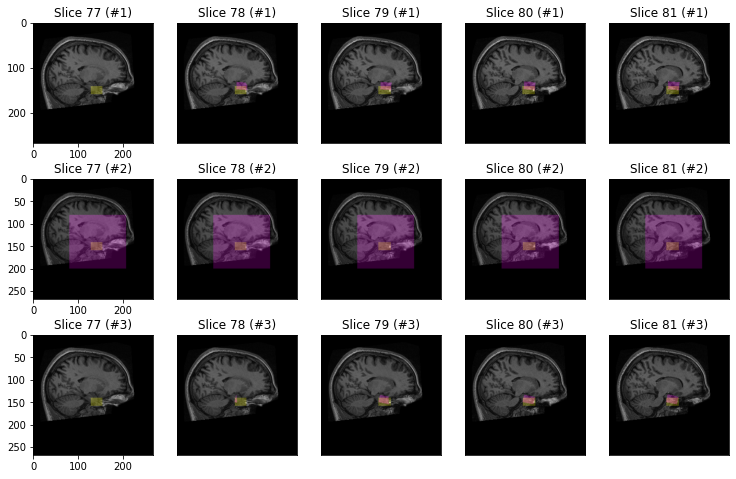

In [43]:
# Row 1 = resampled img obj, resampled mask obj
# Row 2 = reconverted img obj, reconverted mask bj

ax0_range = lrange(77,82)

viz_axis(np_arr = input_arr, \
        bin_mask_arr   = input_mask_arr, color1 = "yellow", alpha1=0.3, \
        bin_mask_arr2  = pred_mask_arr,  color2 = "magenta", alpha2=0.3, \
        slices=ax0_range, fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = input_arr, \
        bin_mask_arr_b   = input_mask_arr, color1_b = "yellow", alpha1_b=0.3, \
        bin_mask_arr2_b  = coords2mask(input_arr.shape, csc_coords), color2_b = "magenta", alpha2_b=0.3, \
        slices_b = ax0_range, fixed_axis_b=0, \
        axis_fn_b = np.rot90, \
         
        np_arr_c = input_arr, \
        bin_mask_arr_c   = input_mask_arr, color1_c = "yellow", alpha1_c=0.3, \
        bin_mask_arr2_c  = csc2full_mask(input_arr.shape, csc_coords, csc_pred_mask_arr), color2_c = "magenta", alpha2_c=0.3, \
        slices_c = ax0_range, fixed_axis_c=0, \
        axis_fn_c = np.rot90, \
         
        grid = [3, 5], hspace=0.3, fig_mult=2)

In [ ]:
input_idx, atlas_idx

In [ ]:
# Row 1 = resampled img obj, resampled mask obj
# Row 2 = reconverted img obj, reconverted mask bj

viz_axis(np_arr = input_arr, \
        bin_mask_arr   = input_mask_arr, color1 = "yellow", alpha1=0.3, \
        bin_mask_arr2  = atlas_mask_arr,  color2 = "magenta", alpha2=0.3, \
        slices=lrange(82,87), fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = atlas_arr, \
        bin_mask_arr_b   = atlas_mask_arr, color1_b = "yellow", alpha1_b=0.3, \
        bin_mask_arr2_b  = input_mask_arr, color2_b = "magenta", alpha2_b=0.3, \
        slices_b = lrange(82, 87), fixed_axis_b=0, \
        axis_fn_b = np.rot90, \
         
        grid = [2, 5], hspace=0.3, fig_mult=2)

In [ ]:
# from IPython.display import Javascript
# display(Javascript('IPython.notebook.execute_cells_above()'))

In [ ]:
# store the img, mask arrs
memo = {}

def np2rs(arr, reference_frame = reference_frame):
    # check
    _, _, reference_origin, reference_spacing, reference_direction, _ = reference_frame
    image = sitk.GetImageFromArray(arr)
    image.SetOrigin(reference_origin)
    image.SetSpacing(reference_spacing)
    image.SetDirection(reference_direction)
    return image

# mask2bbox(sitk2np(atlas2pred(input_obj, atlas_obj, atlas_mask_obj)))
def idxs2pred_memo_all(input_idx, atlas_idx):
    
    # objs = img_obj, mask_obj
    
    if input_idx in memo:
        input_obj      = np2rs(memo[input_idx][0])
        input_mask_obj = np2rs(memo[input_idx][1])
    else:
        input_obj, input_mask_obj = idx2obj(input_idx)        
        # store (img arr, mask arr) in memo
        memo[input_idx] = sitk.GetArrayFromImage(input_obj), \
                          sitk.GetArrayFromImage(input_mask_obj)
        
    if atlas_idx in memo:
        atlas_obj      = np2rs(memo[atlas_idx][0])
        atlas_mask_obj = np2rs(memo[atlas_idx][1])
    else:
        atlas_obj, atlas_mask_obj = idx2obj(atlas_idx)
        memo[atlas_idx] = sitk.GetArrayFromImage(atlas_obj), \
                          sitk.GetArrayFromImage(atlas_mask_obj)
    
    # ground truth = input mask obj
    gt_bbox   = mask2bbox(sitk2np(input_mask_obj))
    
    # predicted = atlas2pred mask obj
    pred_mask_obj = atlas2pred(input_obj, atlas_obj, atlas_mask_obj)
    pred_bbox = mask2bbox(sitk2np(pred_mask_obj))
   
    return pred_bbox, gt_bbox

# mask2bbox(sitk2np(atlas2pred(input_obj, atlas_obj, atlas_mask_obj)))
def idxs2pred_bbox(input_idx, atlas_idx):
    
    # objs = img_obj, mask_obj
    input_obj, input_mask_obj = idx2obj(input_idx)  
    atlas_obj, atlas_mask_obj = idx2obj(atlas_idx)
    
    # ground truth = input mask obj
    gt_bbox   = mask2bbox(sitk2np(input_mask_obj))
    
    # predicted = atlas2pred mask obj
    pred_mask_obj = atlas2pred(input_obj, atlas_obj, atlas_mask_obj)
    pred_bbox = mask2bbox(sitk2np(pred_mask_obj))
   
    # store bbox's in memo
    for idx,bbox in ((input_idx, gt_bbox), (atlas_idx, mask2bbox(sitk2np(atlas_mask_obj)))):
        if idx not in memo: memo[idx] = bbox

    memo[(input_idx, atlas_idx)] = pred_bbox
    
    return pred_bbox, gt_bbox

In [ ]:
# start = time.time()
# test = [idxs2pred_bbox(input_idx, atlas_idx) for input_idx, atlas_idx in idxs]
# elapsed = time.time() - start
# print(elapsed)
# print(len(idxs))

In [ ]:
# 923/120

In [ ]:
# import pickle

# with open('bbox_dict.pickle', 'wb') as handle:
#     pickle.dump(bbox_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('bbox_dict.pickle', 'rb') as handle:
#     bbox_dict2 = pickle.load(handle)

# print(bbox_dict2 == bbox_dict)

In [ ]:
# import pickle

# with open('bbox_dict.pickle', 'rb') as handle:
#     bbox_dict = pickle.load(handle)


In [ ]:
# def get_bbox_diff(input_idx, atlas_idx): 
#     gt_bbox   = bbox_dict[input_idx]
#     pred_bbox = bbox_dict[(input_idx, atlas_idx)]
    
#     diff = (x1-x2 for x1,x2 in zip(gt_bbox, pred_bbox))
#     cols = "delta_imin", "delta_imax", "delta_jmin", "delta_jmax", "delta_kmin", "delta_kmax"
#     return dict(zip(cols, diff))

In [ ]:
# delta_df = DF([get_bbox_diff(*key) for key in bbox_dict.keys() if type(key)==tuple])

In [ ]:
# delta_df

In [ ]:
# delta_df.boxplot(column=["delta_imin", "delta_imax", "delta_jmin", "delta_jmax", "delta_kmin", "delta_kmax"])

Symmetrical boxplot => equally likely to be above/below

Full size: (191, 268, 268)
Half size: (85, 134, 134)

Axis 0:
- imin: expand margin by at least 10
- imax: expand margin by at least 10

Axis 1:
- jmin: at least 15
- jmax: at least 15
  
Axis 2:
- kmin: at least 15
- kmax: at least 15

Padding total: 40 slices, 50 & 60

In [ ]:
# Full size: (191, 268, 268) 
# Half size: (85, 134, 134)

imin_range = np.arange(10, 90, step=10)
imax_range = np.arange(10, 90, step=10)

jmin_range = np.arange(15, 125, step=10)
jmax_range = np.arange(15, 125, step=10)

kmin_range = np.arange(15,125, step=10)
kmax_range = np.arange(15,125, step=10)

In [ ]:
imin_range = np.arange(10, 50, step=20)
imax_range = np.arange(10, 50, step=20)

jmin_range = np.arange(15, 75, step=30)
jmax_range = np.arange(15, 75, step=30)

kmin_range = np.arange(15,75, step=30)
kmax_range = np.arange(15,75, step=30)

In [ ]:
pad_ranges = (imin_range, imax_range, jmin_range, jmax_range, kmin_range, kmax_range)
for r in pad_ranges:
    print(f"Len {len(r):2}: ", r)

from functools import reduce
product = reduce((lambda x, y: x * y), [len(r) for r in pad_ranges])
print(f"Total No. Parameter Combinations: {product}.")

In [ ]:
# store the img, mask arrs
csc_memo = {}
csc_errors = {}

def bbox2diff(gt_bbox, pred_bbox): 
    diff = (x1-x2 for x1,x2 in zip(gt_bbox, pred_bbox))
    cols = "delta_imin", "delta_imax", "delta_jmin", "delta_jmax", "delta_kmin", "delta_kmax"
    return dict(zip(cols, diff))

def crop2roi(objs, bbox_coords, mult_factor=1):
    
    imin, imax, jmin, jmax, kmin, kmax = bbox_coords    
    sizes = [sz*mult_factor for sz in (imax-imin, jmax-jmin, kmax-kmin)]
    pads  = [halve(x) for x in sizes]
    
    # HACKY
    #pads = [30, 70, 70]
    
    imin_pad, jmin_pad, kmin_pad = [max(0, m-pad) for m,pad in zip((imin, jmin, kmin), pads)]
    imax_pad, jmax_pad, kmax_pad = [min(sz, m+pad) for m,pad,sz in zip((imax, jmax, kmax), pads, objs[0].GetSize())]
    
    
    return      (*[o[imin_pad:imax_pad, jmin_pad:jmax_pad, kmin_pad:kmax_pad] for o in objs], \
                (imin_pad, imax_pad, jmin_pad, jmax_pad, kmin_pad, kmax_pad))

# mask2bbox(sitk2np(atlas2pred(input_obj, atlas_obj, atlas_mask_obj)))
def idxs2csc_bbox(input_idx, atlas_idx, pad_amts):
    
    # pad dict
    pad_cols    = "pad_imin", "pad_imax", "pad_jmin", "pad_jmax", "pad_kmin", "pad_kmax"
    pad_dict    = dict(zip(pad_cols, pad_amts)) 
    
    print("Getting obj")
    
    # objs = img_obj, mask_obj
    input_obj, input_mask_obj = idx2obj(input_idx)  
    atlas_obj, atlas_mask_obj = idx2obj(atlas_idx)
    
    input_arr, gt_mask_arr    = (sitk2np(o) for o in (input_obj, input_mask_obj))
    atlas_arr, atlas_mask_arr = (sitk2np(o) for o in (atlas_obj, atlas_mask_obj))
    
    sz = input_obj.GetSize()
    
    del input_obj
    del input_mask_obj
    del atlas_obj
    del atlas_mask_obj
    
    print("Loaded obj")
    
    # ground truth = input mask obj
    #gt_mask_arr   = sitk2np(input_mask_obj).astype(bool)
    gt_bbox       = mask2bbox(gt_mask_arr)
    
    print("Getting pred")
    
    # predicted = atlas2pred mask obj
    pred_mask_arr = atlas2pred(input_arr, atlas_arr, atlas_mask_arr)
    pred_bbox     = mask2bbox(pred_mask_arr)
    
    # metric
    align0_dice = compute_dice_coefficient(gt_mask_arr, pred_mask_arr)
    
    print("Starting csc")
    
    # cascade: expand margin around pred_bbox
    imin, imax, jmin, jmax, kmin, kmax = pred_bbox
    imin_pad, imax_pad, jmin_pad, jmax_pad, kmin_pad, kmax_pad = pad_amts
    
    mins     = imin, jmin, kmin
    maxs     = imax, jmax, jmax
    min_pads = imin_pad, jmin_pad, kmin_pad
    max_pads = imax_pad, jmax_pad, kmax_pad
    
    imin, jmin, kmin = [max(0, x-pad) for x,pad in zip(mins, min_pads)]
    imax, jmax, kmax = [min(x-pad, shape) for x,pad,shape in zip(maxs, max_pads, sz)]
    
    # slice obj
    slc = np.s_[imin:imax, jmin:jmax, kmin:kmax]
    
    # cascade: re-align sub-brain (ROI + margin) region
    csc = True
    try:
        csc_gt_mask_arr   = input_mask_arr[slc]  
        csc_pred_mask_arr = atlas2pred(input_arr[slc], atlas_arr[slc], atlas_mask_arr[slc])
        
        print("End csc")
        
        print("mask2bbox")
        csc_pred_bbox   = mask2bbox(pred_mask_arr)
        csc_gt_bbox     = mask2bbox(csc_gt_mask_arr)
        
        # metric
        align1_dice = compute_dice_coefficient(csc_gt_mask_arr, csc_pred_mask_arr)
        
    except:
        print("Error")
        csc = False
        
        csc_pred_bbox = pred_bbox
        csc_gt_bbox   = gt_bbox
        align1_dice   = align0_dice
        
        # store error
        if (input_idx, atlas_idx) in csc_errors:
            csc_errors[(input_idx, atlas_idx)].append(pad_dict)
        else:
            csc_errors[(input_idx, atlas_idx)] = [pad_dict]

   
    print("Return row")
    
    # store input idx, atlas idx, pad amts, bbox delta between gt and pred 
    return {"input_idx": input_idx, "atlas_idx": atlas_idx, \
            "align0": align0, "align1": align1, "csc": csc, \
            **pad_dict, **bbox2diff(csc_gt_bbox, csc_pred_bbox)}

In [ ]:
idxs[0]

In [ ]:
imin_range = np.arange(10, 50, step=20)
imax_range = np.arange(10, 50, step=20)

jmin_range = np.arange(15, 75, step=30)
jmax_range = np.arange(15, 75, step=30)

kmin_range = np.arange(15,75, step=30)
kmax_range = np.arange(15,75, step=30)

In [ ]:
pad_ranges = (imin_range, imax_range, jmin_range, jmax_range, kmin_range, kmax_range)
for r in pad_ranges:
    print(f"Len {len(r):2}: ", r)

from functools import reduce
product = reduce((lambda x, y: x * y), [len(r) for r in pad_ranges])
print(f"Total No. Parameter Combinations: {product}.")

In [ ]:
params = [(imin_pad, imax_pad, jmin_pad, jmax_pad, kmin_pad, kmax_pad) \
          for imin_pad in imin_range \
          for imax_pad in imax_range \
          for jmin_pad in jmin_range \
          for jmax_pad in jmax_range \
          for kmin_pad in kmin_range \
          for kmax_pad in kmax_range
         ]

In [ ]:
print(f"Len params {len(params)}")
print(*params[-10:], sep="\n")

In [ ]:
print([(a,b,c) for a,b in [(0,1), (2,3)] for c in [("a", "a", "a"), ("b", "b", "b")]])

In [ ]:
# part 0

input_idx, atlas_idx = idxs[0]
pad_amts = params[0]

print(input_idx, atlas_idx, pad_amts)

In [ ]:
start = time.time()
test = idxs2csc_bbox(input_idx, atlas_idx, pad_amts)
elapsed = time.time() - start
print(elapsed)

In [ ]:
# pad dict
pad_cols    = "pad_imin", "pad_imax", "pad_jmin", "pad_jmax", "pad_kmin", "pad_kmax"
pad_dict    = dict(zip(pad_cols, pad_amts)) 

print(pad_dict)

print("Getting obj")

# objs = img_obj, mask_obj
input_obj, input_mask_obj = idx2obj(input_idx)  
atlas_obj, atlas_mask_obj = idx2obj(atlas_idx)

print("Loaded obj")

# ground truth = input mask obj
gt_mask_arr   = sitk2np(input_mask_obj).astype(bool)
gt_bbox       = mask2bbox(gt_mask_arr)

print("Getting pred")

In [ ]:
from helpers_predict import get_parameter_map

elastixImageFilter = sitk.ElastixImageFilter()

# set parameter map
parameterMapVector = sitk.VectorOfParameterMap()
parameterMapVector.append(get_parameter_map("affine"))

elastixImageFilter.SetParameterMap(parameterMapVector)

# set moving and fixed images (resample moving=>fixed using T:fixed=>moving)

# input = fixed, atlas = moving
elastixImageFilter.SetFixedImage(input_obj)
elastixImageFilter.SetMovingImage(atlas_obj)
elastixImageFilter.Execute()

#pred_obj = elastixImageFilter.GetResultImage()

# MAP MOVING (ATLAS BINARY ROI) ONTO FIXED (INPUT) 

# set moving image (atlas)                                                    
transformixImageFilter = sitk.TransformixImageFilter()
transformixImageFilter.SetMovingImage(atlas_mask_obj)

# set parameter map (Binary mask => nearest neighbor final interpolation)
transformedParameterMapVector = elastixImageFilter.GetTransformParameterMap()
transformedParameterMapVector[-1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
transformixImageFilter.SetTransformParameterMap(transformedParameterMapVector)

# Execute transformation
transformixImageFilter.Execute()

pred_mask_obj = transformixImageFilter.GetResultImage()

In [ ]:
pred_mask_arr = sitk2np(pred_mask_obj)

In [ ]:
pred_bbox     = mask2bbox(pred_mask_arr)

In [ ]:
pred_bbox

In [ ]:
from IPython.display import Javascript
display(Javascript('IPython.notebook.execute_cells_above()'))

In [ ]:
t = atlas2pred(input_obj, atlas_obj, atlas_mask_obj)

In [ ]:
t2 = sitk2np(t).astype(bool)

In [ ]:
mask2bbox(t2)

In [ ]:
# pred_mask_obj = transformixImageFilter.GetResultImage()

In [ ]:
# predicted = atlas2pred mask obj
pred_mask_arr = sitk2np(atlas2pred(input_obj, atlas_obj, atlas_mask_obj)).astype(bool)

In [ ]:
pred_mask_arr.astype(bool)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# your real data here - some 3d boolean array
ax.voxels(gt_mask_arr)

plt.show()

In [ ]:
s

In [ ]:
pred_bbox     = mask2bbox(pred_mask_arr)

In [ ]:
# metric
align0_dice = compute_dice_coefficient(gt_mask_arr, pred_mask_arr)

print("Starting csc")

# cascade: expand margin around pred_bbox
imin, imax, jmin, jmax, kmin, kmax = pred_bbox
imin_pad, imax_pad, jmin_pad, jmax_pad, kmin_pad, kmax_pad = pad_amts

imin, jmin, kmin = [max(0, x-pad) for x,pad in zip((imin, jmin, kmin), (imin_pad, jmin_pad, kmin_pad))]
imax, jmax, kmax = [min(x-pad, shape) for x,pad,shape in zip((imin, jmin, kmin), \
                                                             (imin_pad, jmin_pad, kmin_pad), \
                                                             input_obj.GetSize())]

In [ ]:
s

In [ ]:
# predicted = atlas2pred mask obj
pred_mask_arr = sitk2np(atlas2pred(input_obj, atlas_obj, atlas_mask_obj))
pred_bbox     = mask2bbox(pred_mask_arr)

# metric
align0_dice = compute_dice_coefficient(gt_mask_arr, pred_mask_arr)

In [ ]:
start = time.time()
test = idxs2csc_bbox(*idxs[0], params[0])
elapsed = time.time() - start
print(f"Elapsed {elapsed}")

In [ ]:
test = DF([idxs2csc_bbox(input_idx, atlas_idx, pad_amts) for input_idx, atlas_idx in idxs[:1] \
                                                         for pad_amts in params[:1]])

In [ ]:
s

In [ ]:
# https://github.com/microsoft/WSL/issues/4166

# start = time.time()
# parallel_test4 = Parallel(n_jobs=4)(delayed(idxs2pred_bbox)(input_idx=i[0], atlas_idx=i[1]) for i in idxs)
# elapsed = time.time() - start
# print(elapsed)

#### By how much is pred1 off?

In [ ]:
# test atlas0 and atlas 5
def get_pred_bbox(input_idx, atlas_idx):
    
       
    pred_bbox_coord = mask2bbox(sitk2np(atlas2pred(rs_objs[input_idx][0], *rs_objs[atlas_idx])))
    
    pimin, pimax, pjmin, pjmax, pkmin, pkmax = pred_bbox_coord
    roi_size0, roi_size1, roi_size2    = pimax-pimin, pjmax-pjmin, pkmax-pkmin
        
    return {
        f"input_idx": input_idx, \
        f"atlas_idx": atlas_idx, \
        "roi_size0": roi_size0, "roi_size1": roi_size1, "roi_size2": roi_size2, \
        "imin": imin, "imax":imax, \
        "jmin":jmin, "jmax": jmax, \
        "kmin": kmin, "kmax": kmax
    }
        
   

In [ ]:
start = time.time()
pred_bboxs = DF([get_pred_bbox(*idx_pair) for idx_pair in idxs])
elapsed = time.time() - start
print(elapsed)

In [ ]:
pred_bbox_df = DataFrame(pred_bboxs)
pred_bbox_df

In [ ]:
def get_pred_bbox_coords(input_idx, atlas_idx):
    return pred_bbox_df[(pred_bbox_df["input_idx"] == input_idx)&(pred_bbox_df["atlas_idx"]==atlas_idx)][["imin", "imax", "jmin", "jmax", "kmin", "kmax"]].values[0]

def get_input_bbox_coords(input_idx):
    return input_bbox_coords[input_idx]

In [ ]:
def get_bbox_diff(pred_bbox, gt_bbox): 
    diff = (x1-x2 for x1,x2 in zip(gt_bbox, pred_bbox))
    cols = "delta_imin", "delta_imax", "delta_jmin", "delta_jmax", "delta_kmin", "delta_kmax"
    return dict(zip(cols, diff))

def get_keys(d, key_list):
    return [d[k] for k in key_list]

In [ ]:
bbox_diffs = [{"input_idx": input_idx, "atlas_idx": atlas_idx, \
               **get_bbox_diff(get_pred_bbox_coords(input_idx, atlas_idx), get_input_bbox_coords(input_idx))} \
              for input_idx in range(0,5) for atlas_idx in (0, 5)]

In [ ]:
bbox_diffs = DataFrame(bbox_diffs)
bbox_diffs

In [ ]:
bbox_diffs.boxplot(column=["delta_imin", "delta_imax", "delta_jmin", "delta_jmax", "delta_kmin", "delta_kmax"])